In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples  

# ─────────────────────────────────────────────────────────────────────────────
# Parameters
# ─────────────────────────────────────────────────────────────────────────────
seed = 1010
torch.manual_seed(seed)
np.random.seed(seed)

# ─────────────────────────────────────────────────────────────────────────────
# Load Data (z and w)
# ─────────────────────────────────────────────────────────────────────────────
# Parameters for simulation
n1 = 100         
n2 = 1000        
delta1 = 1      
delta2 = 100   
theta1_true = 0 
theta2_true = 1 

# Simulate first module samples
z = np.random.normal(theta1_true, 1, n1)
w = np.random.normal(theta2_true, 1, n2)

w = torch.tensor(w, dtype=torch.float32) 

# ─────────────────────────────────────────────────────────────────────────────
# Parameters dimenion
# ─────────────────────────────────────────────────────────────────────────────
dim_theta = 1      
dim_context = 1    

# ─────────────────────────────────────────────────────────────────────────────
# Simulate phi_samples ~ p(phi | z)
# ─────────────────────────────────────────────────────────────────────────────
M_MC = 1000       
phi_mean = (n1 * np.mean(z)) / (n1 + delta1)
phi_std = np.sqrt(1 / (n1 + delta1))
phi_samples_np = np.random.normal(loc=phi_mean, scale=phi_std, size=M_MC)
phi_samples = torch.tensor(phi_samples_np, dtype=torch.float32).view(-1, dim_context)

# ─────────────────────────────────────────────────────────────────────────────
# Define Prior and Likelihood
# ─────────────────────────────────────────────────────────────────────────────
def prior_log_prob_fn(theta):
    """
    log p(θ) where θ ~ N(0, I / delta2)
    """
    prior_std = 1.0 / np.sqrt(delta2)
    return Normal(0.0, prior_std).log_prob(theta).sum(-1)

def likelihood_log_prob_fn(theta, phi, data_w):
    """
    log p(w | θ, ϕ) where w ~ N(θ + ϕ, 1)
    - theta: shape [N, p_theta]
    - phi: shape [N, p_eta]
    - data_w: vector of w observations [n2]
    """
    theta_sum = theta.sum(-1, keepdim=True) 
    mu = theta_sum + phi  
    mu_expanded = mu.expand(-1, data_w.shape[0])
    log_likelihood = Normal(mu_expanded, 1.0).log_prob(data_w).sum(-1)
    return log_likelihood

# ─────────────────────────────────────────────────────────────────────────────
# Initialize Model
# ─────────────────────────────────────────────────────────────────────────────
hidden_dim = 32   
num_layers = 2    
n_epochs = 1000    
lr = 0.002        

model = CutBayesFlow(
    prior_log_prob_fn=prior_log_prob_fn,
    likelihood_log_prob_fn=likelihood_log_prob_fn,
    eta_dim=dim_context,
    theta_dim=dim_theta,
    num_layers=num_layers,
    hidden_features=hidden_dim,
    num_bins=16,
    tail_bound=20.0,
    use_residual_blocks=True,
    num_blocks=2
)

# ─────────────────────────────────────────────────────────────────────────────
# Train Model
# ─────────────────────────────────────────────────────────────────────────────
print("Training NeVI-Cut on biased_data...")
loss_history = train_cut_bayes_flow(
    model,
    phi_samples,
    data_D2=w,
    epochs=n_epochs,
    lr=lr,
    verbose=True,
    seed = 1010,
    log_interval=500
)



Training NeVI-Cut on biased_data...
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 9517.768555 | LR: 2.00e-03
Epoch 00144: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00330: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00431: reducing learning rate of group 0 to 2.5000e-04.
Step   500 | Loss: 1465.281738 | LR: 2.50e-04
Epoch 00532: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00633: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00734: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00835: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00936: reducing learning rate of group 0 to 7.8125e-06.
Step   999 | Loss: 1465.164673 | LR: 7.81e-06


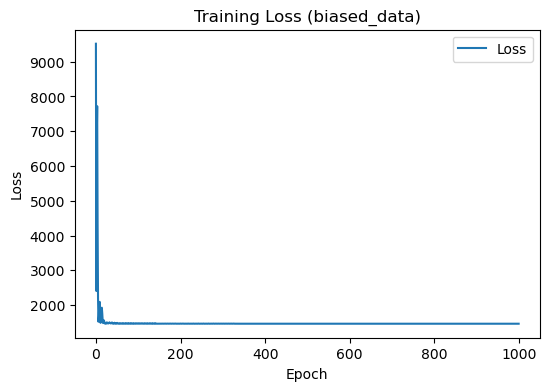

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot Loss Curve
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 4))
plt.plot(loss_history, label="Loss")
plt.title("Training Loss (biased_data)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



Generated 100/1000 samples
Generated 200/1000 samples
Generated 300/1000 samples
Generated 400/1000 samples
Generated 500/1000 samples
Generated 600/1000 samples
Generated 700/1000 samples
Generated 800/1000 samples
Generated 900/1000 samples
Generated 1000/1000 samples


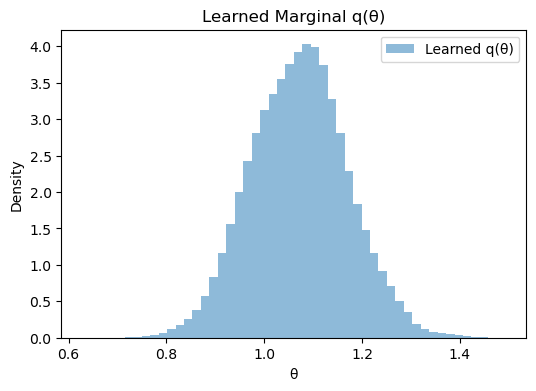

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Sample from Learned Marginal q(θ)
# ─────────────────────────────────────────────────────────────────────────────
n_iterations = 1000
theta_samples_q = get_marginal_samples(model, phi_samples, n_iterations=n_iterations)
theta_samples_q_flat = theta_samples_q.reshape(-1).detach().cpu().numpy()

# Plot Histogram of q(θ)
plt.figure(figsize=(6, 4))
plt.hist(theta_samples_q_flat, bins=50, density=True, alpha=0.5, label="Learned q(θ)")
plt.title("Learned Marginal q(θ)")
plt.xlabel("θ")
plt.ylabel("Density")
plt.legend()
plt.show()


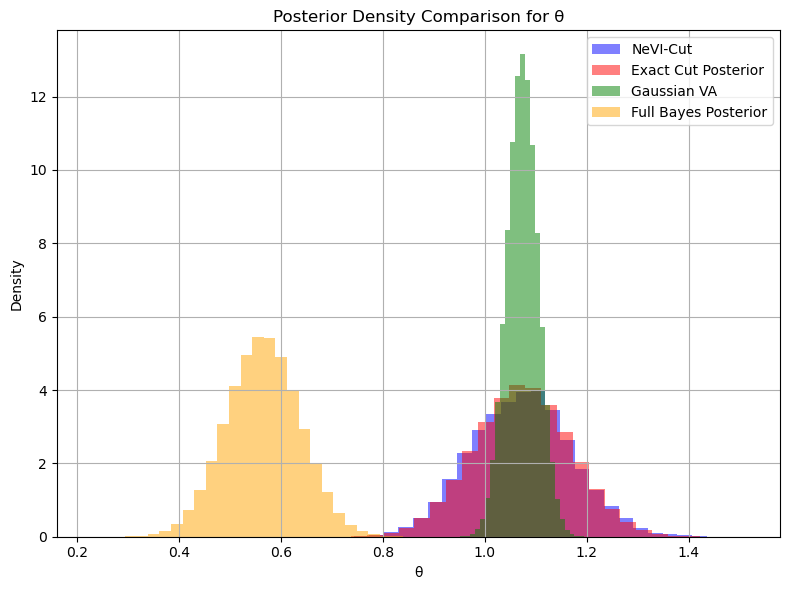

In [4]:
# --------------------------------------------------------
# Compute Closed-form Posterior Approximations
# --------------------------------------------------------
# Posterior mean and covariance for full model (exact)
Sigma_inv = np.array([[n1 + delta1 + n2, n2],
                      [n2, n2 + delta2]])
Sigma = np.linalg.inv(Sigma_inv)

b = np.array([
    [n1 * np.mean(z) + n2 * np.mean(w.detach().cpu().numpy())],
    [n2 * np.mean(w.detach().cpu().numpy())]
])
mu = np.dot(Sigma, b) 

# NN Cut Bayes samples (from learned flow)
samples_mu = theta_samples_q.reshape(-1).detach().cpu().numpy()

# Exact Cut Posterior
mu_phi = n1 * np.mean(z) / (n1 + delta1)
exact_mean = (np.mean(w.detach().cpu().numpy()) - mu_phi) * n2 / (delta2 + n2)
exact_var = 1 / (delta2 + n2) + (n2 / (n2 + delta2))**2 / (n1 + delta1)
samples_exact = np.random.normal(exact_mean, np.sqrt(exact_var), size=samples_mu.shape[0])

# VI Posterior (mean-field style)
vi_mean = (np.mean(w.detach().cpu().numpy()) - mu_phi) * n2 / (delta2 + n2)
vi_var = 1 / (delta2 + n2)
samples_vi = np.random.normal(vi_mean, np.sqrt(vi_var), size=samples_mu.shape[0])

# Full Joint Posterior: extract θ component (second entry)
samples_exact_full = np.random.normal(mu[1, 0], np.sqrt(Sigma[1, 1]), size=samples_mu.shape[0])

# --------------------------------------------------------
# Plot
# --------------------------------------------------------

plt.figure(figsize=(8, 6))
plt.hist(samples_mu, bins=30, density=True, alpha=0.5, label='NeVI-Cut', color='blue')
plt.hist(samples_exact, bins=30, density=True, alpha=0.5, label='Exact Cut Posterior', color='red')
plt.hist(samples_vi, bins=30, density=True, alpha=0.5, label='Gaussian VA', color='green')
plt.hist(samples_exact_full, bins=30, density=True, alpha=0.5, label='Full Bayes Posterior', color='orange')

plt.title("Posterior Density Comparison for θ")
plt.xlabel("θ")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
